<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/4%20Aprendizaje%20reforzado/Sesion%206/1_basic_vs_egreedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estrategia $\epsilon$-greedy con bandits Gaussianos**

In [1]:
# Adaptado de:
#
# https://deeplearningcourses.com/c/artificial-intelligence-reinforcement-learning-in-python
# https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python

In [2]:
!ls

sample_data


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm as gaussiana

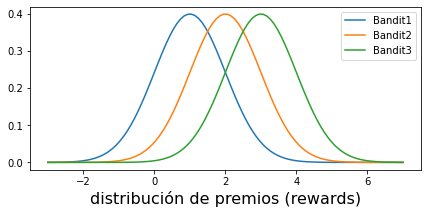

In [4]:
m1   = 1. # medias y desviaciones estándar de los premios (rewards) que da cada bandit
std1 = 1.
m2   = 2
std2 = 1.
m3   = 3.
std3 = 1.

plt.figure(figsize=(7,3))
premios = np.linspace(-3,7,100)
plt.plot(premios, gaussiana.pdf(x=premios, loc=m1, scale=std1), label='Bandit1')
plt.plot(premios, gaussiana.pdf(x=premios, loc=m2, scale=std2), label='Bandit2')
plt.plot(premios, gaussiana.pdf(x=premios, loc=m3, scale=std3), label='Bandit3')
plt.xlabel('distribución de premios (rewards)', fontsize=16)
plt.legend();

In [5]:
# Simulación de las máquinas tragaperras

class Bandit:
    def __init__(self, mean, std=1, addseed=0): # se inicializa bandit
        self.mean = mean
        np.random.seed(1234567+int(str(mean).replace(".",""))+addseed)
        # se generan todas las futuras salidas de Bandit
        self.maxpulls = 1000000
        self.futurepulls = self.mean + std*np.random.randn(self.maxpulls)
        self.n = 0 # la primera salida
    
    def pull(self): # se acciona bandit
        aux = self.futurepulls[self.n]
        self.n = self.n + 1
        
        if self.n == self.maxpulls:
            self.n = 0
        
        # el if anterior es equivalente a:
        # self.n = (self.n + 1) % self.maxpulls
        return aux

In [6]:
m1, std1

(1.0, 1.0)

In [8]:
bandit1 = Bandit(m1, std1)

In [9]:
bandit1.pull()

1.645375630631098

In [10]:
len(bandit1.futurepulls)

1000000

In [11]:
bandit1.pull()

0.3991628573871264

In [12]:
bandit1.pull()

2.0626057016223527

In [13]:
bandit1.pull()

0.8215971345861959

In [14]:
N=10000
premios1 = [bandit1.pull() for _ in range(N)]

In [15]:
premios1[:10]

[0.19756718115157557,
 1.0450912845770286,
 0.5636865217365836,
 0.7190230719845304,
 0.26936601688325057,
 0.17796934640860373,
 0.024942227139659545,
 0.8902535855162822,
 0.6822010745903749,
 2.2386981876296304]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


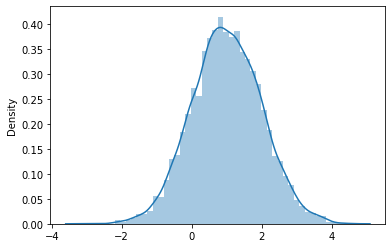

In [16]:
sns.distplot(premios1);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

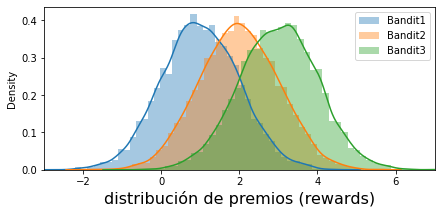

In [17]:
bandit1 = Bandit(m1, std1)
bandit2 = Bandit(m2, std2)
bandit3 = Bandit(m3, std3)

premios1 = [bandit1.pull() for _ in range(N)]
premios2 = [bandit2.pull() for _ in range(N)]
premios3 = [bandit3.pull() for _ in range(N)]

plt.figure(figsize=(7,3))
sns.distplot(premios1, label='Bandit1')
sns.distplot(premios2, label='Bandit2')
sns.distplot(premios3, label='Bandit3')
plt.xlim(-3,7)
plt.xlabel('distribución de premios (rewards)', fontsize=16)
plt.legend();

In [18]:
N = 100000

In [19]:
class estimacion_Bandit: # estimación del valor Q del Bandit
    def __init__(self):
        # se inicializan todas las estimaciones a 0
        self.suma_premios = 0
        self.N = 0
        self.mean = 0
        
    def update(self, x): # ahora obtengo premio x en la máquina
        self.suma_premios += x
        self.N += 1
        self.mean = self.suma_premios / self.N # estimación de Q

In [20]:
# Estrategia básica:
# - Primero se explora aleatoriamente
# - Cuando se ha explorado aleatoriamente, se procede a elegir siempre el bandit con mejor
#   estadística en la fase de exploración

def run_experiment_basic(bandits, N_total, N_explore, vis=True):
    estimated_bandits = [estimacion_Bandit() for _ in bandits]
    
    rewards = np.empty(N_total)
    
    for i in range(N_total):
        if i < N_explore: # fase de explotación (elijo una máquina al azar)
            j = np.random.choice(3)
        else: # fase de explotación: elijo la máquina con mayor mean (Q estimada)
            j = np.argmax([y.mean for y in estimated_bandits])
        
        x = bandits[j].pull()
        estimated_bandits[j].update(x)
        # para dibujar luego:
        rewards[i] = x
        
    cumulative_reward  = np.cumsum(rewards)
    cumulative_average = cumulative_reward / (np.arange(N) + 1)

    if vis:
        # plot moving average ctr
        plt.figure(figsize=(7,3))
        x = np.array(range(1,N+1))
        plt.plot(x, N*[bandits[0].mean], label='bandit 1 real mean')
        plt.plot(x, N*[bandits[1].mean], label='bandit 2 real mean')
        plt.plot(x, N*[bandits[2].mean], label='bandit 3 real mean')
        plt.plot(x, cumulative_average, label='average reward')
        plt.title('basic, N_explore={}'.format(N_explore), fontsize=16)
        plt.xscale('log')
        plt.legend(loc=4)
        plt.show()
    
        for i,b in enumerate(estimated_bandits):
            print('media estimada del bandit {}: {}'.format(i+1,np.round(b.mean,3)))
    
    return cumulative_reward, cumulative_average

In [21]:
np.random.choice(10)

6

In [22]:
def run_experiment_egreedy(bandits, epsilon, N_total, vis=True):
    estimated_bandits = [estimacion_Bandit() for _ in bandits]
    
    rewards = np.empty(N_total)
    
    for i in range(N_total):
        # epsilon greedy
        p = np.random.random()
        if p < epsilon: # explorar
            j = np.random.choice(3)
        else: # explotar
            j = np.argmax([b.mean for b in estimated_bandits])
        
        x = bandits[j].pull()
        estimated_bandits[j].update(x)
        # para dibujar:
        rewards[i] = x
        
    cumulative_reward  = np.cumsum(rewards)
    cumulative_average = cumulative_reward / (np.arange(N) + 1)

    if vis:
        # plot moving average ctr
        plt.figure(figsize=(7,3))
        x = np.array(range(1,N+1))
        plt.plot(x, N*[bandits[0].mean], label='bandit 1 real mean')
        plt.plot(x, N*[bandits[1].mean], label='bandit 2 real mean')
        plt.plot(x, N*[bandits[2].mean], label='bandit 3 real mean')
        plt.plot(x, cumulative_average, label='average reward')
        plt.title('$\epsilon$-greedy, $\epsilon$={}'.format(epsilon), fontsize=16)
        plt.xscale('log')
        plt.legend(loc=4)
        plt.show()
    
        for i,b in enumerate(estimated_bandits):
            print('media estimada del bandit {}: {}'.format(i+1,np.round(b.mean,3)))
    
    return cumulative_reward, cumulative_average

In [23]:
def run_experiment_egreedy_edecay(bandits, k, N_total, vis=True):
    estimated_bandits = [estimacion_Bandit() for _ in bandits]
    
    rewards = np.empty(N_total)
    #epsilon = 1.
    epsilons = []
    for i in range(N_total):
        epsilon = min(1, k/(i+1))
        epsilons.append(epsilon)
        # epsilon greedy
        p = np.random.random()
        if p < epsilon: # explorar
            j = np.random.choice(3)
        else: # explotar
            j = np.argmax([b.mean for b in estimated_bandits])
        
        x = bandits[j].pull()
        estimated_bandits[j].update(x)
        # para dibujar:
        rewards[i] = x
        
    cumulative_reward  = np.cumsum(rewards)
    cumulative_average = cumulative_reward / (np.arange(N) + 1)

    if vis:
        # plot moving average ctr
        plt.figure(figsize=(7,3))
        x = np.array(range(1,N+1))
        plt.plot(x, N*[bandits[0].mean], label='bandit 1 real mean')
        plt.plot(x, N*[bandits[1].mean], label='bandit 2 real mean')
        plt.plot(x, N*[bandits[2].mean], label='bandit 3 real mean')
        plt.plot(x, cumulative_average, label='average reward')
        plt.title('$\epsilon$-greedy, $\epsilon$={}'.format(epsilon), fontsize=16)
        plt.xscale('log')
        plt.legend(loc=4)
        plt.show()
        plt.figure(figsize=(7,3))
        x = np.array(range(1,N+1))
        plt.plot(x, epsilons, label='epsilon')
        plt.legend(loc=4)
        plt.xscale('log')
        plt.show()
    
        for i,b in enumerate(estimated_bandits):
            print('media estimada del bandit {}: {}'.format(i+1,np.round(b.mean,3)))
    
    return cumulative_reward, cumulative_average

In [24]:
def run_experiment_egreedy_edecay2(bandits, decay, N_total, vis=True):
    estimated_bandits = [estimacion_Bandit() for _ in bandits]
    # decay: (0,1)
    rewards = np.empty(N_total)
    epsilon = 1.
    epsilons = []
    for i in range(N_total):
        epsilons.append(epsilon)
        # epsilon greedy
        p = np.random.random()
        if p < epsilon: # explorar
            j = np.random.choice(3)
        else: # explotar
            j = np.argmax([b.mean for b in estimated_bandits])
        
        x = bandits[j].pull()
        estimated_bandits[j].update(x)
        # para dibujar:
        rewards[i] = x
        epsilon = epsilon*decay
        
    cumulative_reward  = np.cumsum(rewards)
    cumulative_average = cumulative_reward / (np.arange(N) + 1)

    if vis:
        # plot moving average ctr
        plt.figure(figsize=(7,3))
        x = np.array(range(1,N+1))
        plt.plot(x, N*[bandits[0].mean], label='bandit 1 real mean')
        plt.plot(x, N*[bandits[1].mean], label='bandit 2 real mean')
        plt.plot(x, N*[bandits[2].mean], label='bandit 3 real mean')
        plt.plot(x, cumulative_average, label='average reward')
        plt.title('$\epsilon$-greedy, $\epsilon$={}'.format(epsilon), fontsize=16)
        plt.xscale('log')
        plt.legend(loc=4)
        plt.show()
        plt.figure(figsize=(7,3))
        x = np.array(range(1,N+1))
        plt.plot(x, epsilons, label='epsilon')
        plt.legend(loc=4)
        #plt.xscale('log')
        plt.show()
    
        for i,b in enumerate(estimated_bandits):
            print('media estimada del bandit {}: {}'.format(i+1,np.round(b.mean,3)))
    
    return cumulative_reward, cumulative_average

**Experimento básico**

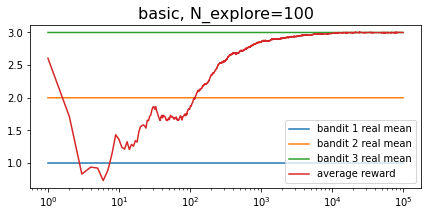

media estimada del bandit 1: 0.888
media estimada del bandit 2: 2.045
media estimada del bandit 3: 3.0


In [25]:
bandit1 = Bandit(m1, std1, addseed=10)
bandit2 = Bandit(m2, std2, addseed=10)
bandit3 = Bandit(m3, std3, addseed=10)

N_explore_basic = 5
N_explore_basic = 100
total_reward_basic, average_reward_basic  = run_experiment_basic([bandit1, bandit2, bandit3],
                                                                 N_total=N, N_explore=N_explore_basic)

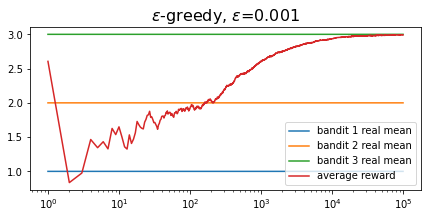

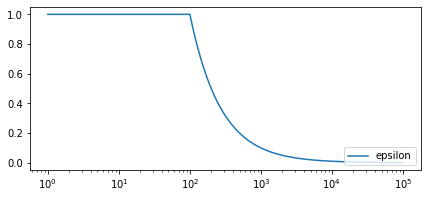

media estimada del bandit 1: 0.866
media estimada del bandit 2: 2.025
media estimada del bandit 3: 3.0


In [26]:
bandit1 = Bandit(m1, std1, addseed=10)
bandit2 = Bandit(m2, std2, addseed=10)
bandit3 = Bandit(m3, std3, addseed=10)
bandits = [bandit1, bandit2, bandit3]

N = 100000
k = 100
total_reward_basic, average_reward_basic = run_experiment_egreedy_edecay(bandits, k, N)

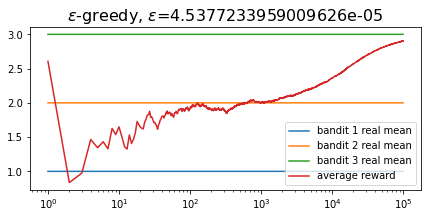

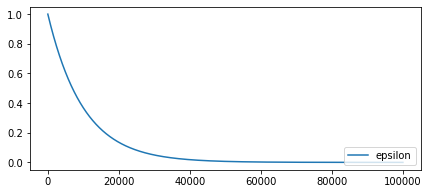

media estimada del bandit 1: 1.007
media estimada del bandit 2: 2.009
media estimada del bandit 3: 3.002


In [27]:
bandit1 = Bandit(m1, std1, addseed=10)
bandit2 = Bandit(m2, std2, addseed=10)
bandit3 = Bandit(m3, std3, addseed=10)
bandits = [bandit1, bandit2, bandit3]

N = 100000
decay = 0.9999 # epsilon = epsilon_ini*exp(-k*t)
total_reward_basic, average_reward_basic = run_experiment_egreedy_edecay2(bandits, decay, N)

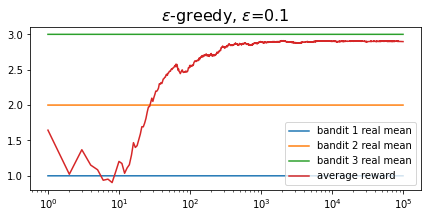

media estimada del bandit 1: 1.003
media estimada del bandit 2: 1.984
media estimada del bandit 3: 2.999






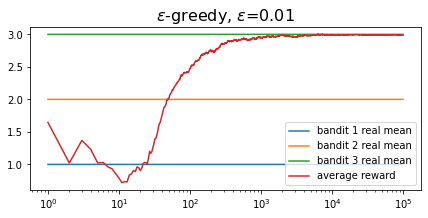

media estimada del bandit 1: 1.018
media estimada del bandit 2: 1.923
media estimada del bandit 3: 2.998






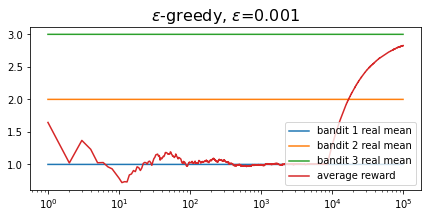

media estimada del bandit 1: 1.004
media estimada del bandit 2: 1.66
media estimada del bandit 3: 2.999






In [28]:
epsilons = [1e-1, 1e-2, 1e-3]

total_rewards = []
average_rewards = []
for e in epsilons:
    bandit1 = Bandit(m1, std1)
    bandit2 = Bandit(m2, std2)
    bandit3 = Bandit(m3, std3)

    total_reward, average_reward  = run_experiment_egreedy([bandit1, bandit2, bandit3],
                                                           epsilon=e, N_total=N)
    total_rewards.append(total_reward)
    average_rewards.append(average_reward)
    print("\n\n\n")

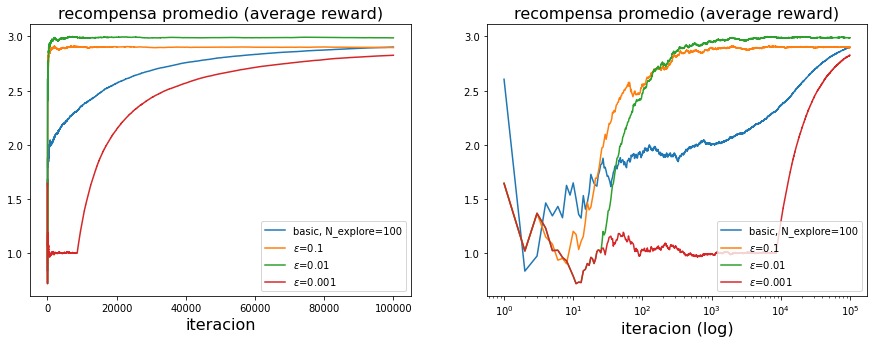

In [29]:
plt.figure(figsize=(15,5))

# linear plot
plt.subplot(1,2,1)
x = np.array(range(1,N+1))
plt.plot(x, average_reward_basic, label='basic, N_explore={}'.format(N_explore_basic))
for average_reward, e in zip(average_rewards, epsilons):
    plt.plot(x, average_reward, label='$\epsilon$={}'.format(e))
plt.legend(loc=4)
plt.xlabel('iteracion', fontsize=16)
plt.title('recompensa promedio (average reward)', fontsize=16)

# log scale plot
plt.subplot(1,2,2)
plt.plot(x, average_reward_basic, label='basic, N_explore={}'.format(N_explore_basic))
for average_reward, e in zip(average_rewards, epsilons):
    plt.plot(x, average_reward, label='$\epsilon$={}'.format(e))
plt.legend(loc=4)
plt.xscale('log')
plt.xlabel('iteracion (log)', fontsize=16)
plt.title('recompensa promedio (average reward)', fontsize=16);

**Coste de oportunidad: para calcularlo hay que calcular el premio que consigo si desde el inicio apuesto "con trampa" al mejor bandit**

In [ ]:
plt.figure(figsize=(5,5))
max_m = max([m1,m2,m3])
optimal_bandit = Bandit(max_m)
optimal_gains = [optimal_bandit.pull() for _ in range(N)]

plt.plot(x, np.cumsum(optimal_gains) - total_reward_basic, label='basic, N_explore={}'.format(N_explore_basic))
for total_reward, e in zip(total_rewards, epsilons):
    plt.plot(x, np.cumsum(optimal_gains) - total_reward, label='$\epsilon$={}'.format(e))
plt.legend(loc=0)
plt.xlabel('iteracion (log)', fontsize=16)
plt.title('total coste oportunidad ("regret")', fontsize=16);

**Ahora hago un promedio de diferentes repeticiones**

In [ ]:
Nreps = 50
N = 10000
total_reward_matrix = np.empty((4,Nreps,N))
average_reward_matrix = np.empty((4,Nreps,N))
for i,e in enumerate([-1]+epsilons):
    for rep in range(Nreps):
        if e == -1:
            print("\rbasic, N_explore={}, repetición {}/{}".format(N_explore_basic, rep+1, Nreps),end="")
            bandits = [Bandit(m1, std1, addseed=rep),
                       Bandit(m2, std2, addseed=rep),
                       Bandit(m3, std3, addseed=rep)]
            total_reward, average_reward  = run_experiment_basic(bandits, N_total=N,
                                                                 N_explore=N_explore_basic,
                                                                 vis=False)
        else:
            print("\repsilon={}, repetición {}/{}".format(e, rep+1, Nreps),end="")
            bandits = [Bandit(m1, std1, addseed=rep),
                       Bandit(m2, std2, addseed=rep),
                       Bandit(m3, std3, addseed=rep)]
            total_reward, average_reward  = run_experiment_egreedy(bandits, epsilon=e,
                                                                   N_total=N, vis=False)
        
        total_reward_matrix[i][rep] = total_reward
        average_reward_matrix[i][rep] = average_reward
    print()

In [ ]:
plt.figure(figsize=(15,5))
x = np.array(range(1,N+1))
aux_a = average_reward_matrix.mean(axis=1)
aux_a_std = average_reward_matrix.std(axis=1)
# log scale plot
plt.subplot(1,2,1)
for i in range(4):
    if i == 0:
        plt.plot(x, aux_a[0], label='basic, N_explore={}'.format(N_explore_basic))
    else:
        plt.plot(x, aux_a[i], label='$\epsilon$={}'.format(epsilons[i-1]))
plt.legend(loc=4)
plt.xlabel('iteración (log)', fontsize=16)
plt.title('recompensa promedio (average reward)', fontsize=16)

aux_t = total_reward_matrix.mean(axis=1)
aux_t_std = total_reward_matrix.std(axis=1)
plt.subplot(1,2,2)
max_m = max([m1,m2,m3])
optimal_bandit = Bandit(mean=max_m)
optimal_gains = [optimal_bandit.pull() for _ in range(N)]

for i in range(4):
    if i==0:
        plt.plot(x, np.cumsum(optimal_gains) - aux_t[i], label='basic, N_explore={}'.format(N_explore_basic))
    else:
        plt.plot(x, np.cumsum(optimal_gains) - aux_t[i], label='$\epsilon$={}'.format(epsilons[i-1]))
plt.legend(loc=0)
plt.xlabel('iteración (log)', fontsize=16)
plt.title('total coste oportunidad ("regret")', fontsize=16);